# NEURAL NETWORKS AND DEEP LEARNING

---
Scaramuzza Luca 2019132 - Homework 1
---


# Set up the environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cpu


In [4]:
torch.manual_seed(0)

# Import Dataset

In [5]:
!wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/train_data.csv
!wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/test_data.csv 

--2022-02-12 14:36:17--  https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/train_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3776 (3.7K) [text/plain]
Saving to: ‘regression_dataset/train_data.csv’

train_data.csv      100%[===================>]   3.69K  --.-KB/s    in 0s      

2022-02-12 14:36:18 (48.2 MB/s) - ‘regression_dataset/train_data.csv’ saved [3776/3776]

--2022-02-12 14:36:18--  https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/test_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3788 (3.7K) [text/plain]
Saving to: ‘regression_dataset/test_data.csv’

test_data.csv 

In [6]:
train_df = pd.read_csv('regression_dataset/train_data.csv').values
test_df = pd.read_csv('regression_dataset/test_data.csv').values

X_train = train_df[:,0]
y_train = train_df[:,1]

X_test = test_df[:,0]
y_test = test_df[:,1]

In [7]:
X_train=np.expand_dims(X_train, axis=1)
y_train=np.expand_dims(y_train, axis=1)
X_test=np.expand_dims(X_test, axis=1)
y_test=np.expand_dims(y_test, axis=1)

X_train=torch.from_numpy(X_train).float()
y_train=torch.from_numpy(y_train).float()
X_test=torch.from_numpy(X_test).float()
y_test=torch.from_numpy(y_test).float()

# Simple Regressor model

## Model definition

In [8]:
class SimpleReg(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No):
        super().__init__()
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.out = nn.Linear(in_features=Nh2, out_features=No)
        self.act = nn.ReLU()
        
    def forward(self, x, additional_out=False):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.out(x)
        return x

## Simple classifier training with initial parameters

In [9]:
!pip install skorch
from skorch import NeuralNetRegressor

net = NeuralNetRegressor(
    module=SimpleReg,
    module__Ni= 1,
    module__Nh1 = 32,
    module__Nh2 = 32,
    module__No = 1,
    max_epochs=1000,
    
    device=device,
    optimizer = optim.Adam,
    optimizer__lr=0.001,
    optimizer__weight_decay=1e-5, #L2 norm
    criterion=nn.MSELoss,
    #callbacks = [my_early],
    verbose=0
)

     |████████████████████████████████| 155 kB 5.3 MB/s 


In [10]:
net.fit(X_train,y_train)

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=SimpleReg(
    (fc1): Linear(in_features=1, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=32, bias=True)
    (out): Linear(in_features=32, out_features=1, bias=True)
    (act): ReLU()
  ),
)

## Plot losses and accuracy

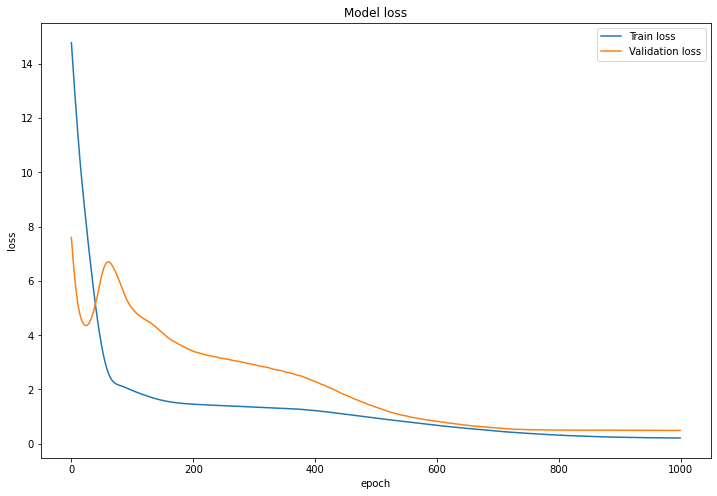

In [11]:
history = net.history
train_loss_log = history[:, 'train_loss']
val_loss_log = history[:, 'valid_loss']

plt.figure(figsize=(12,8))
plt.plot(train_loss_log)
plt.plot(val_loss_log)
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train loss', 'Validation loss'], loc='upper right')
plt.show()

In [12]:
y_pred = net.predict(X_test)
y_pred = torch.from_numpy(y_pred).float()

loss_function = nn.MSELoss()
test_loss = loss_function(y_pred, y_test)
print(f"TEST LOSS: {test_loss}")

TEST LOSS: 0.19072061777114868


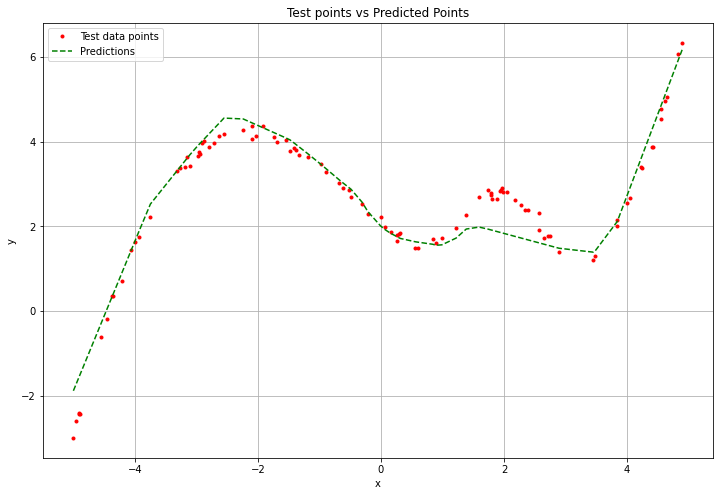

In [13]:
zipped_lists = zip(X_test, y_pred)
sorted_pairs = sorted(zipped_lists)

tuples = zip(*sorted_pairs)
X, y = [ list(tuple) for tuple in  tuples]

plt.figure(figsize=(12,8))
plt.plot(X_test, y_test, color='r', ls='', marker='.')
plt.plot(X, y, color='g', ls='--')
plt.title('Test points vs Predicted Points')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend(['Test data points', 'Predictions'], loc='upper left')
plt.show()

## Grid search

In [14]:
from sklearn.model_selection import GridSearchCV

params = {
    'module__Nh1': [16,32,64],
    'module__Nh2': [16,32,64],
    'max_epochs': [1000],
    'optimizer__lr':[0.01, 0.001],
    'optimizer__weight_decay':[1e-3,1e-4,1e-5]
}

gs = GridSearchCV(net, params, refit=True, cv=3, verbose=0)

gs.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=SimpleReg(
    (fc1): Linear(in_features=1, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=32, bias=True)
    (out): Linear(in_features=32, out_features=1, bias=True)
    (act): ReLU()
  ),
),
             param_grid={'max_epochs': [1000], 'module__Nh1': [16, 32, 64],
                         'module__Nh2': [16, 32, 64],
                         'optimizer__lr': [0.01, 0.001],
                         'optimizer__weight_decay': [0.001, 0.0001, 1e-05]})

In [15]:
print(gs.best_score_, gs.best_params_)

-2.0081658282550783 {'max_epochs': 1000, 'module__Nh1': 64, 'module__Nh2': 64, 'optimizer__lr': 0.01, 'optimizer__weight_decay': 0.001}


## Simple classifier training with parameters found with grid search

In [16]:
net=gs.best_estimator_
net.fit(X_train, y_train)

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=SimpleReg(
    (fc1): Linear(in_features=1, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=64, bias=True)
    (out): Linear(in_features=64, out_features=1, bias=True)
    (act): ReLU()
  ),
)

## Plot losses and accuracy

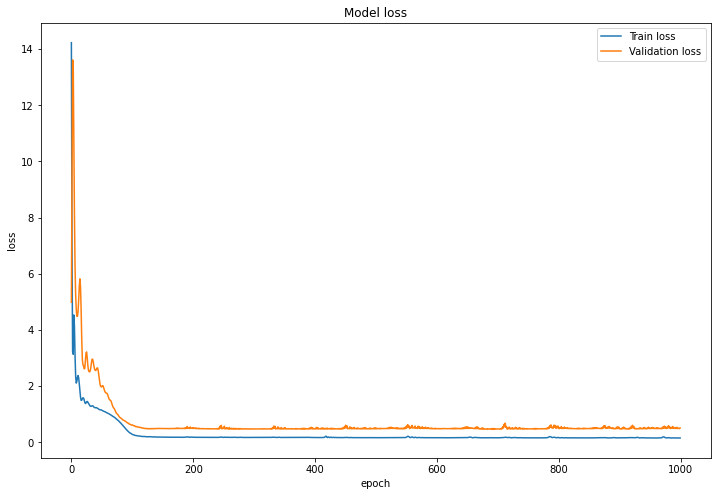

In [17]:
history = net.history
train_loss_log=history[:, 'train_loss']
val_loss_log=history[:, 'valid_loss']

plt.figure(figsize=(12,8))
plt.plot(train_loss_log)
plt.plot(val_loss_log)
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train loss', 'Validation loss'], loc='upper right')
plt.show()

In [18]:
y_pred = net.predict(X_test)
y_pred = torch.from_numpy(y_pred).float()

loss_function = nn.MSELoss()
test_loss = loss_function(y_pred, y_test)
print(f"TEST LOSS: {test_loss}")

TEST LOSS: 0.12616553902626038


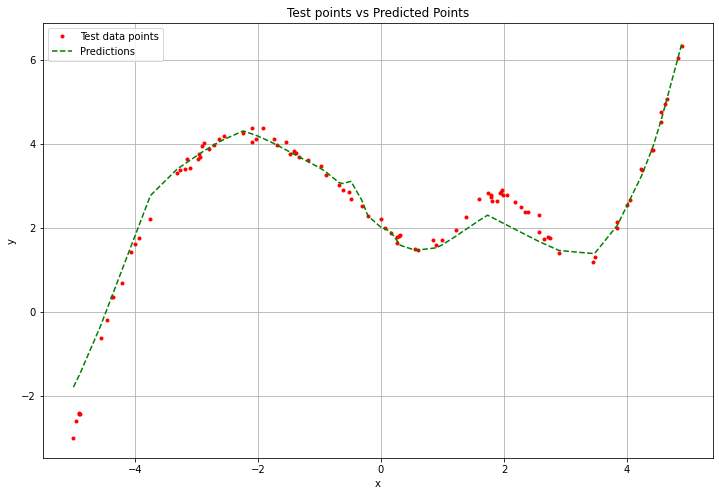

In [19]:
zipped_lists = zip(X_test, y_pred)
sorted_pairs = sorted(zipped_lists)

tuples = zip(*sorted_pairs)
X, y = [ list(tuple) for tuple in  tuples]

plt.figure(figsize=(12,8))
plt.plot(X_test, y_test, color='r', ls='', marker='.')
plt.plot(X, y, color='g', ls='--')
plt.title('Test points vs Predicted Points')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend(['Test data points', 'Predictions'], loc='upper left')
plt.show()

In [20]:
train_loss=train_loss_log[-1]

#Val loss
val_loss=val_loss_log[-1]

print("Train Loss:\t",round(train_loss,3))
print("Val Loss:\t",round(val_loss,3))
print("Test Loss:\t",round(float(test_loss),3))

Train Loss:	 0.154
Val Loss:	 0.509
Test Loss:	 0.126


# Models analysis

## Weight histogram

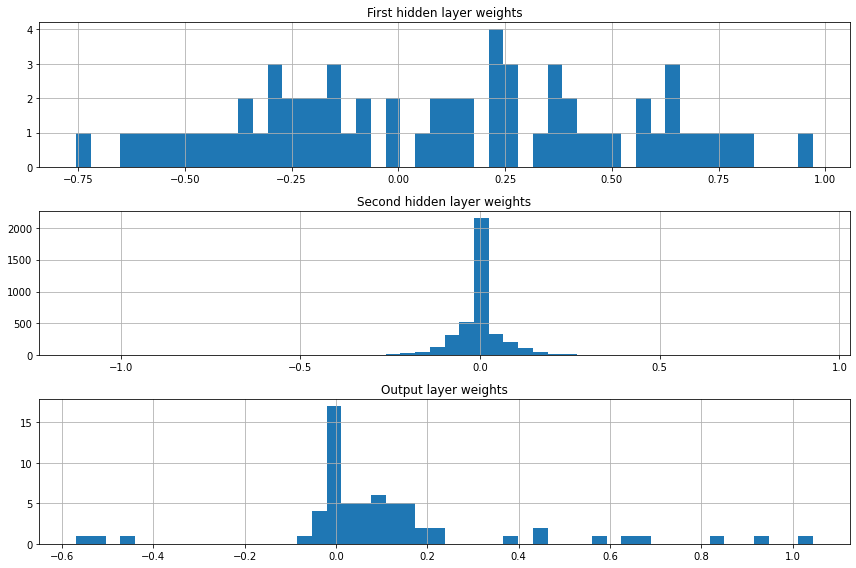

In [21]:
h1_w = net.module_.fc1.weight.data.cpu().numpy()
h1_b = net.module_.fc1.bias.data.cpu().numpy()

h2_w = net.module_.fc2.weight.data.cpu().numpy()
h2_b = net.module_.fc2.bias.data.cpu().numpy()

out_w = net.module_.out.weight.data.cpu().numpy()
out_b = net.module_.out.bias.data.cpu().numpy()

fig, axs = plt.subplots(3, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_title('First hidden layer weights')
axs[1].hist(h2_w.flatten(), 50)
axs[1].set_title('Second hidden layer weights')
axs[2].hist(out_w.flatten(), 50)
axs[2].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

## Activation profiles

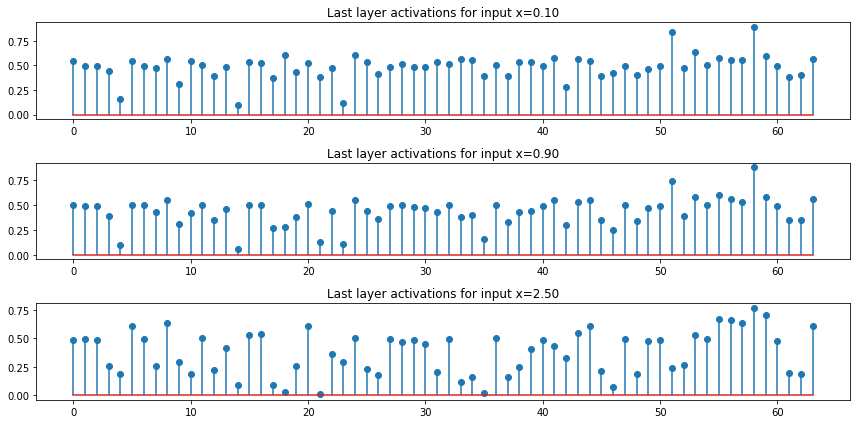

In [22]:
def get_activation(layer, input, output):
    global activation
    activation = torch.sigmoid(output)
    
hook_handle = net.module_.fc2.register_forward_hook(get_activation)

net = net.module_.to(device)
net.eval()
with torch.no_grad():
    x1 = torch.tensor([0.1]).float().to(device)
    y1 = net(x1)
    z1 = activation
    x2 = torch.tensor([0.9]).float().to(device)
    y2 = net(x2)
    z2 = activation
    x3 = torch.tensor([2.5]).float().to(device)
    y3 = net(x3)
    z3 = activation

hook_handle.remove()

fig, axs = plt.subplots(3, 1, figsize=(12,6))
axs[0].stem(z1.cpu().numpy(), use_line_collection=True)
axs[0].set_title('Last layer activations for input x=%.2f' % x1)
axs[1].stem(z2.cpu().numpy(), use_line_collection=True)
axs[1].set_title('Last layer activations for input x=%.2f' % x2)
axs[2].stem(z3.cpu().numpy(), use_line_collection=True)
axs[2].set_title('Last layer activations for input x=%.2f' % x3)
plt.tight_layout()
plt.show()